In [1]:
import glob,time
import pylab as pl
import numpy as np
import matplotlib
import astropy.io.fits as fits
import matplotlib.pyplot as plt

from   astropy.table import Table, vstack, join
from   desimodel.focalplane.geometry import xy2radec 
from   desimodel.io import load_fiberpos 
from   desitarget.geomask import circles 
from   desitarget.sv3.sv3_targetmask import desi_mask, bgs_mask, mws_mask 

import healpy as hp
import pandas as pd
import matplotlib.gridspec as gridspec
from astropy.io import fits as fits
from astropy import constants as const
from astropy import units as u
from astropy.table import QTable

import math

import sys
sys.path.append('/global/homes/l/lbigwood/LSS/py')
import LSS
import LSS.SV3
import LSS.SV3.cattools as cattools

from desitarget.geomask import get_imaging_maskbits 

nside = 32
orig_density_per_deg = 2500 #random

#files
sv3_randoms = '/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/random0/rancomb_brightwdup_Alltiles.fits'
main_survey_randoms = '/global/cfs/cdirs/desi/target/catalogs/dr9/0.49.0/randoms/resolve/randoms-1-0.fits'

In [2]:
#this is just the function from cattools ive used before 
def tile2rosette(tile):
    if tile < 433:
        return (tile-1)//27
    else:
        if tile >= 433 and tile < 436:
            return 13
        if tile >= 436 and tile < 439:
            return 14
        if tile >= 439 and tile < 442:
            return 15
        if tile >= 442 and tile <=480:
            return (tile-442)//3
            
        if tile > 480:
            return tile//30    
    return 999999 #shouldn't be any more?

In [3]:
#again finding bright and completed tiles from sv3 list and adding column for rosette
tiles = Table.read('/global/cscratch1/sd/mjwilson/S4MOCK/tiles-sv3.ecsv')
tiles = tiles[(tiles['STATUS'] == 'done') & (tiles['PROGRAM']=='BRIGHT')]
tiles['ROSETTE'] = np.array([tile2rosette(x) for x in tiles['TILEID']])
tiles

TILEID,PASS,RA,DEC,PROGRAM,IN_DESI,PRIORITY,STATUS,EBV_MED,DESIGNHA,DONEFRAC,AVAILABLE,ROSETTE
int64,int32,float64,float64,str6,bool,float64,str8,float32,float32,float32,bool,int64
12,0,150.04,2.286,BRIGHT,True,0.000e+00,done,0.022782475,0.00,1.0455,False,0
13,1,150.061,2.069,BRIGHT,True,0.000e+00,done,0.023243327,0.00,1.1505,False,0
14,2,150.212,2.226,BRIGHT,True,0.000e+00,done,0.022683823,0.00,1.0456,False,0
15,3,149.98,2.171,BRIGHT,True,0.000e+00,done,0.023039486,0.00,1.1052,False,0
16,4,150.187,2.099,BRIGHT,True,0.000e+00,done,0.023041949,0.00,1.0776,False,0
17,5,150.106,2.302,BRIGHT,True,0.000e+00,done,0.022638734,0.00,1.1865,False,0
18,6,149.993,2.237,BRIGHT,True,0.000e+00,done,0.022844847,0.00,1.4589,False,0
19,7,150.128,2.065,BRIGHT,True,0.000e+00,done,0.023041053,0.00,1.3565,False,0
20,8,150.17,2.28,BRIGHT,True,0.000e+00,done,0.02263027,0.00,1.1368,False,0


In [4]:
#printing rosettes in sv3
np.unique(tiles['ROSETTE'].data)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [5]:
cmap = matplotlib.cm.get_cmap("magma", 20)

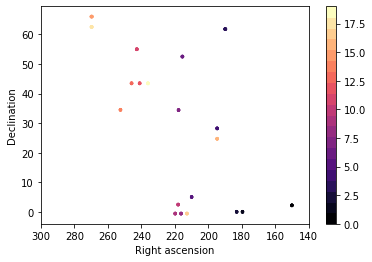

In [6]:
#plotting tile ra and dec and colour coding by rosette
#hasnt matched with fiber assigned tiles - how has this worked???
#I guess because of the overlap as we make passes 

pl.scatter(tiles['RA'], tiles['DEC'], marker='.', lw=0.0, c=tiles['ROSETTE'], cmap=cmap)
pl.xlim(300., 140.)
pl.xlabel('Right ascension')
pl.ylabel('Declination')
pl.colorbar()

In [7]:
# glob.glob('/global/cscratch1/sd/mjwilson/S4MOCK/SV3REAL/SV3REALLEDGER/bright/*')

In [8]:
#making full sv3 ledger like before
ledger = vstack([Table.read(x) for x in glob.glob('/global/cscratch1/sd/mjwilson/S4MOCK/SV3REAL/SV3REALLEDGER/bright/*')])

In [9]:
#checking when priority init matches priority in total ledger
np.mean(ledger['PRIORITY_INIT'] == ledger['PRIORITY'])

0.6553668048332207

In [10]:
#update ledger so only have targets where initial priority is same as priority, i guess like first run 
ledger    = ledger[ledger['PRIORITY_INIT'] == ledger['PRIORITY']]

In [11]:
#ledger is long 
len(ledger) / 1.e6

1.448765

In [12]:
#list of tile ids for the rosette 15
tids      = tiles['TILEID'].data[tiles['ROSETTE'] == 15]
tids

array([417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427])

In [13]:
#root for fibre assign files 
root      = '/global/cscratch1/sd/mjwilson/S4MOCK/SV3REAL/SV3REALASSIGN/'

In [14]:
#list of all the sv3 nights so far i think
nights    = [x.split('/')[-1] for x in sorted(glob.glob(root + '/*'))]
nights.remove('SV3.ecsv')
nights

['20210405',
 '20210407',
 '20210408',
 '20210409',
 '20210410',
 '20210411',
 '20210412',
 '20210413',
 '20210414',
 '20210415',
 '20210416',
 '20210417',
 '20210418',
 '20210419',
 '20210420',
 '20210422',
 '20210429',
 '20210430',
 '20210501',
 '20210502',
 '20210503',
 '20210504',
 '20210505',
 '20210506',
 '20210507',
 '20210508',
 '20210509',
 '20210510',
 '20210511',
 '20210512',
 '20210513',
 '20210514',
 '20210518',
 '20210521',
 '20210529']

In [15]:
#loads positions of all the fibres 
fp            = load_fiberpos() 

In [16]:
patrol_radii  = 1.48/60. # degrees 

In [17]:
assigned_targets =[]
avail_targets =[]
ra_avail = []
dec_avail = []
ra_assigned = []
dec_assigned = []

#going through all the fibre assign files for the different nights 
for night in nights:
    fbas      = sorted(glob.glob(root + '/' + night + '/fba-*.fits'))
    ts        = np.array([x.split('/')[-1].replace('.fits','').replace('fba-','') for x in fbas]).astype(np.int64)
    
    ts        = ts[np.isin(ts, tids)]
    
    #print(night, ts)
    
    if len(ts) == 0:
        continue

    fig, axes = plt.subplots(len(ts), 1, figsize=(20*len(ts),20))

    if len(ts) == 1:
        axes  = np.array([axes])

    for i, tid in enumerate(ts):
        fpath = root + '/' + night + '/fba-{:06d}.fits'.format(tid)
        tpath = root + '/' + night + '/{:06d}-targ.fits'.format(tid)

        tra   = fits.open(fpath)[1].header['TILERA']
        tdec  = fits.open(fpath)[1].header['TILEDEC']
        
        targ  = Table.read(tpath)
        fba   = Table.read(fpath, hdu='FASSIGN')
        ftarg = Table.read(fpath, hdu='FTARGETS')
        favl  = Table.read(fpath, hdu='FAVAIL')
    
        # Only keep targets available to a good fiber. 
        good_fib = (fba['FIBERSTATUS']==0)
        favl  = favl[np.isin(favl['LOCATION'], fba['LOCATION'].data[good_fib])] 
    
        favl  = join(favl, ledger, keys='TARGETID', join_type='left')
        fba   = join(fba,  ledger, keys='TARGETID', join_type='left')
        
        # Keep only the matches.  What about the rest??
        favl  = favl[~favl['RA'].mask]

        # 
        fba   = fba[fba['FIBERSTATUS'] == 0]

        # Keep available only if unassigned.
        #favl  = favl[~np.isin(favl['TARGETID'].data, fba['TARGETID'])]
        
        gloc  = fba['LOCATION']
        
        # Keep only BGS Bright.
        fba   = fba[(fba['SV3_BGS_TARGET'].data & bgs_mask['BGS_BRIGHT']) != 0] 

        favl  = favl[(favl['SV3_BGS_TARGET'].data & bgs_mask['BGS_BRIGHT']) != 0] 
        
        plt.sca(axes[i])
 
        ra, dec = xy2radec(tra, tdec, fp["X"], fp["Y"])

        circles(ra[ np.isin(fp['LOCATION'], gloc)], dec[ np.isin(fp['LOCATION'], gloc)], s=patrol_radii, alpha=0.1)  
        circles(ra[~np.isin(fp['LOCATION'], gloc)], dec[~np.isin(fp['LOCATION'], gloc)], s=patrol_radii, alpha=0.1, c='r')
    
        # np.mean(np.isin(fba['TARGETID'].data, ledger['TARGETID'].data))
        avail_targets.append(favl['TARGETID'].data)
        assigned_targets.append(fba['TARGETID'].data)
        
        ra_avail.append(favl['RA'].data)
        dec_avail.append(favl['DEC'].data)
        ra_assigned.append(fba['RA'].data)
        dec_assigned.append(fba['DEC'].data)
        
        # Plot targets available to a good fiber.
        pl.plot(favl['RA'].data, favl['DEC'].data, marker='x', lw=0.0, markersize=4, c='k', alpha=0.5)

        # Plot targets assigned to a good fiber.
        pl.plot(fba['TARGET_RA'].data, fba['TARGET_DEC'].data, marker='.', lw=0.0, markersize=2, c='k')
            
    pl.xlabel('Right ascension [deg.]')
    pl.ylabel('Declination [deg.]')        
    pl.title('Tiles {} on night {}'.format(ts, night))
    #pl.show()
    pl.clf()

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [18]:
overall_eff = len(assigned_targets)/len(avail_targets)

ra_avail = np.concatenate(ra_avail)
dec_avail = np.concatenate(dec_avail)
ra_assigned = np.concatenate(ra_assigned)
dec_assigned = np.concatenate(dec_assigned)

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 20 deg 0.00'.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 20 deg 0.00'.
  warnings.warn(


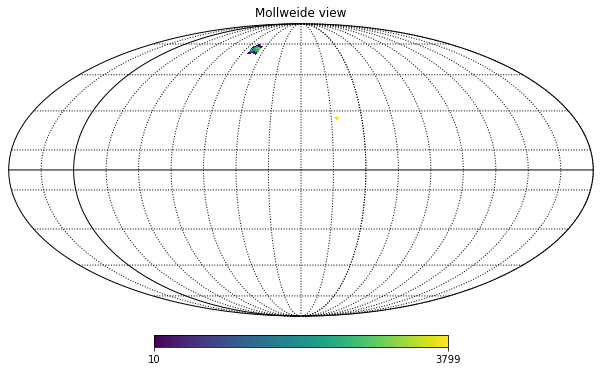

In [19]:
nside=32

theta = np.pi / 2. - np.radians(np.array(dec_assigned))
phi = np.radians(np.array(ra_assigned))

#indices of pixels with non-zero density, unorganised list
all_pixel_indices = hp.ang2pix(nside, theta, phi,nest=True, lonlat=False)

#indice of filled pixels and corrosponding targets in pixel
assigned_filled_pixel_index, assigned_targets_per_pixel = np.unique(all_pixel_indices, return_counts=True) 

#no. targets per pixel, initially 0 
target_pixel_density = np.zeros(hp.nside2npix(nside))

#update no. targets per pixel 
target_pixel_density[assigned_filled_pixel_index] = assigned_targets_per_pixel 
target_pixel_density[target_pixel_density == 0] = np.NaN 

#mollview map of pixels
hp.mollview(target_pixel_density,nest=True,rot=(220, 0.0, 0.0), badcolor='white')
hp.graticule(dpar=5, dmer=5) 

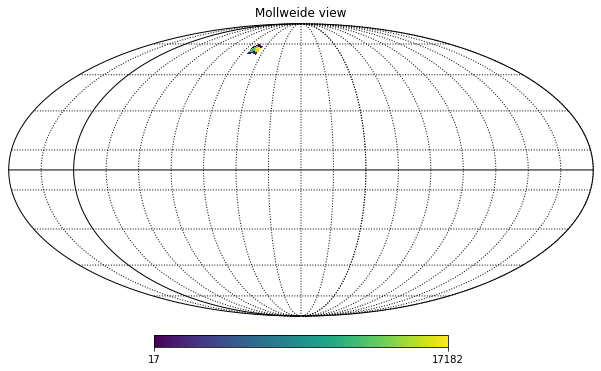

In [20]:
nside=32

theta = np.pi / 2. - np.radians(np.array(dec_avail))
phi = np.radians(np.array(ra_avail))

#indices of pixels with non-zero density, unorganised list
all_pixel_indices = hp.ang2pix(nside, theta, phi,nest=True, lonlat=False)

#indice of filled pixels and corrosponding targets in pixel
avail_filled_pixel_index, avail_targets_per_pixel = np.unique(all_pixel_indices, return_counts=True) 

#no. targets per pixel, initially 0 
target_pixel_density = np.zeros(hp.nside2npix(nside))

#update no. targets per pixel 
target_pixel_density[avail_filled_pixel_index] = avail_targets_per_pixel 
target_pixel_density[target_pixel_density == 0] = np.NaN 

#mollview map of pixels
hp.mollview(target_pixel_density,nest=True,rot=(220, 0.0, 0.0), badcolor='white')
hp.graticule(dpar=5, dmer=5) 

In [45]:
#had to do the isin because there are some assigned targets in diff pixel to avails

eff_array = assigned_targets_per_pixel[np.isin(assigned_filled_pixel_index,avail_filled_pixel_index)]/avail_targets_per_pixel

pixels = assigned_filled_pixel_index[np.isin(assigned_filled_pixel_index,avail_filled_pixel_index)]

print(assigned_filled_pixel_index)
print(avail_filled_pixel_index)

print(assigned_targets_per_pixel)
print(avail_targets_per_pixel)



[2557 2559 2592 2901 2903 3838 3839 4010 4011]
[2557 2559 2901 2903 3838 3839 4010 4011]
[ 241 2415 3799 2869  117  194 1750 2214   10]
[ 1388 15747 17182   470  1107 11537 13357    17]


In [22]:
"""
#apply the bgs masks to the randoms to make the filling factor more accurate

def bgs_mask_randoms(random):    
    
    

    # Apply custom imaging mask around bright stars etc.   
    bitnamelist = ["BRIGHT", "CLUSTER"] 
    bits = get_imaging_maskbits(bitnamelist) 
    retain_random = np.ones(len(random['MASKBITS']), dtype=bool) #got rid of .data as didnt work below 

    for bit, ttype in zip(bits, bitnamelist): 
        # Keep random if bit not set for bits corresponding to BRIGHT and CLUSTER. 
        retain_random &= ((random['MASKBITS'] & 2**bit) == 0)  

        #print to show amount of randoms cut 
        print(ttype, bit, np.mean(retain_random))

    #other cuts
    NOBS_mask = ((random['NOBS_G'] > 0) | (random['NOBS_R'] > 0) | (random['NOBS_Z'] > 0))
    
    #final mask with all masks incorporated 
    retain_random = retain_random & NOBS_mask
 
    #again print to show updated cuts 
    print('NOBS', np.mean(retain_random))

    return random[retain_random]
"""

In [38]:
#open randoms
f = fits.open(sv3_randoms)
random=f[1].data

#check n side in header 

In [39]:
#number of pixels on sphere and pixel area
npix = hp.nside2npix(nside)
pixel_area = hp.nside2pixarea(nside,degrees=True)

print(npix)

12288


/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 20 deg 0.00'.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 20 deg 0.00'.
  warnings.warn(


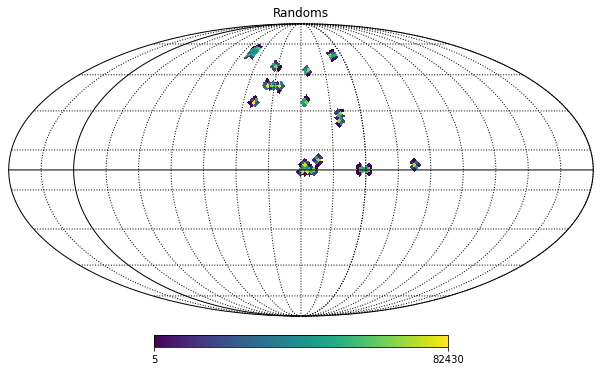

In [46]:
#create mollview map of randoms now they've undergone these cuts 

theta = np.pi / 2. - np.radians(random['DEC'].data)
phi = np.radians(random['RA'].data)

#indices of pixels with non-zero density, unorganised list
all_pixel_indices = hp.ang2pix(nside, theta, phi,nest=True, lonlat=False)

#indice of filled pixels and corrosponding targets in pixel
filled_pixel_index, filled_targets_per_pixel = np.unique(all_pixel_indices, return_counts=True) 

#no. targets per pixel, initially 0 
target_pixel_density = np.zeros(hp.nside2npix(nside))

#update no. targets per pixel 
target_pixel_density[filled_pixel_index] = filled_targets_per_pixel 
target_pixel_density[target_pixel_density == 0] = np.NaN 

#mollview map of pixels
hp.mollview(target_pixel_density,nest=True,rot=(220, 0.0, 0.0), badcolor='white',title='Randoms')
hp.graticule(dpar=5, dmer=5) 
    
#correct pixel area based on actual vs expected density 
exp_density_per_pixel = pixel_area * orig_density_per_deg
filling_factor = target_pixel_density/exp_density_per_pixel
corr_pixel_area = pixel_area * filling_factor 

Text(0.5, 0, 'Random filling factor')

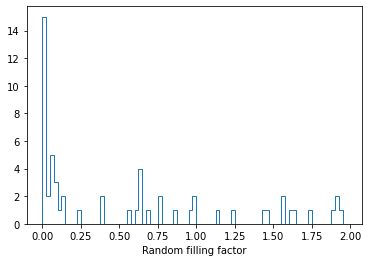

In [47]:
#change to nside =128


#histogram of filling factor: why does it have this shape?
_ = plt.hist(filling_factor, bins=np.arange(0.0, 2.0, 0.025), histtype='step')
plt.xlabel('Random filling factor')

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 20 deg 0.00'.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 20 deg 0.00'.
  warnings.warn(


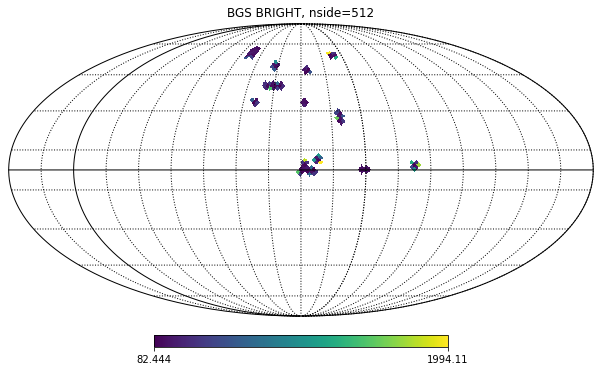

In [32]:
#set coordinates
theta = np.pi / 2. - np.radians(ledger['DEC'].data[ledger['PRIORITY'].data==102100])
phi = np.radians(ledger['RA'].data[ledger['PRIORITY'].data==102100])

#indices of pixels with non-zero density, unorganised list.
all_pixel_indices = hp.ang2pix(nside, theta, phi,nest=True, lonlat=False)

#indice of filled pixels and corrosponding targets in pixel
filled_pixel_index, filled_targets_per_pixel = np.unique(all_pixel_indices, return_counts=True) 

#no. targets per pixel, initially 0 
targets_per_pixel = np.zeros(hp.nside2npix(nside))

#update no. targets per pixel 
targets_per_pixel[filled_pixel_index] = filled_targets_per_pixel
targets_per_pixel[targets_per_pixel == 0] = np.NaN 

#get rid of low density healpixels
targets_per_pixel[(filling_factor < 0.5)] = np.NaN 

target_pixel_density = targets_per_pixel/corr_pixel_area

#mollview map of pixels
hp.mollview(target_pixel_density,nest=True,rot=(220, 0.0, 0.0), badcolor='white',title='BGS BRIGHT, nside=512')
hp.graticule(dpar=5, dmer=5) 

Text(0.5, 0, 'Target density')

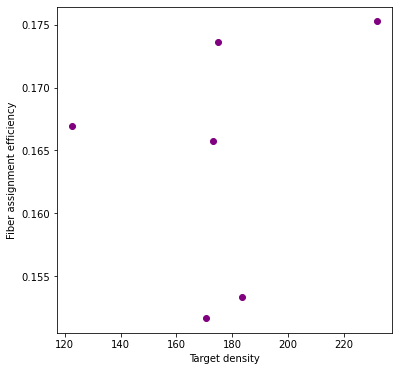

In [33]:
r15_target_density = target_pixel_density[pixels]
plt.figure(figsize=(6,6))
plt.scatter(r15_target_density,eff_array,color='purple')
plt.ylabel('Fiber assignment efficiency')
plt.xlabel('Target density')

In [72]:
g = fits.open(sv3_randoms)
sv3_random=g[1].data

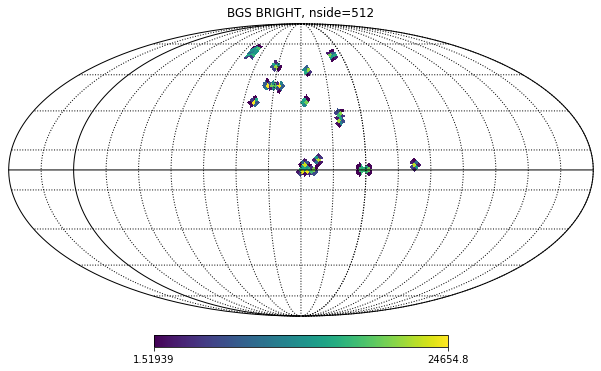

In [74]:
theta = np.pi / 2. - np.radians(sv3_random['DEC'].data)
phi = np.radians(sv3_random['RA'].data)

#indices of pixels with non-zero density, unorganised list.
all_pixel_indices = hp.ang2pix(nside, theta, phi,nest=True, lonlat=False)

#indice of filled pixels and corrosponding targets in pixel
filled_pixel_index, filled_targets_per_pixel = np.unique(all_pixel_indices, return_counts=True) 

#no. targets per pixel, initially 0 
targets_per_pixel = np.zeros(hp.nside2npix(nside))

#update no. targets per pixel 
targets_per_pixel[filled_pixel_index] = filled_targets_per_pixel
targets_per_pixel[targets_per_pixel == 0] = np.NaN 


sv3_target_pixel_density = targets_per_pixel/corr_pixel_area

#mollview map of pixels
hp.mollview(sv3_target_pixel_density,nest=True,rot=(220, 0.0, 0.0), badcolor='white',title='BGS BRIGHT, nside=512')
hp.graticule(dpar=5, dmer=5) 

In [98]:
ra1 = []
dec1 = []
eff1 = []

print(np.array(np.where(all_pixel_indices==pixels[0])))


x = np.where(all_pixel_indices==pixels[0])[0][1]
print(x)


for i in range(len(pixels)):
    for j in range(len(np.where(all_pixel_indices==pixels[i])[0])):
                       
        ra1.append(sv3_random['RA'][np.where(all_pixel_indices==pixels[i])[0][j]])
        dec1.append(sv3_random['DEC'][np.where(all_pixel_indices==pixels[i])[0][j]])
        eff1.append(eff_array[i])


[[3451411 3451412 3451413 ... 3652554 3652555 3652556]]
3451412


KeyboardInterrupt: 

numpy.ndarray

# Done.